# Index
1. [__Encoding__](#section1) <br>
2. [__Recursive Feature Elimination__](#section2) <br>
3. [__Model Flow__](#section3) <br>
4. [__Basic Model__](#section4) <br>
5. [__Model function using Grid SearchCV__](#section5) <br>
6. [__One hot Model using GridSearchCV__](#section6) <br>
7. [__Hashing Model using GridSearchCV__](#section7) <br>
8. [__Backward difference Model using GridSearchCV__](#section8) <br>
    


In [1]:
#Numerical computing packages
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from scipy import stats
from numpy.random import choice
np.random.seed(99)

#jupyter notebook specfic packges
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML, display
pd.options.display.max_columns = None

#visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
from _plotly_future_ import v4_subplots
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import plotly as pl
import missingno as msno

#ML packages
import sklearn
import sklearn.linear_model as linear_model
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import category_encoders as ce
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import mglearn
from sklearn.metrics import accuracy_score,classification_report

#jupyter notebook specfic packges
import warnings
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)
pd.options.display.max_columns = None
from IPython.display import HTML, display



c:\users\nitin mali\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

c:\users\nitin mali\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [2]:
%store -r nnn_newdf

In [3]:
df=nnn_newdf.copy()

In [4]:
#Let's split the model into categorical features and non categorical features
nom_data_df =df.select_dtypes(include=['object']).copy()
ordinal_data_df=df.select_dtypes(include=['int64','float64']).copy()
pred_df=nnn_newdf[['hh_inco']]
#remove the target varibale from the ordinal and continuous data frames 
ordinal_data_df=ordinal_data_df.drop(columns=['hh_inco'])

<a id ='section1'></a>

In [5]:
#encoding the data using one of three methods 

'''
1. One hot encoding 
Since there are many columns with more number of dimensions, the problem might face curse of dimensionality

3. Hashing 
works well if there are many distinct categories. There might be collisions if there are some overlapping columns. But the 
curse of dimensionality is solved.Like OneHot but fewer dimensions, some info loss due to collisions. Nominal, ordinal.

4. Backward difference encoding
the mean of the dependent variable for a level is compared with the mean of the dependent variable for the prior level. 
'''

def onehotencoded(df):
    return pd.get_dummies(df)

def binaryencoded(df):
    #create a binary encoded object
    be=ce.BinaryEncoder(df.columns.values)
    #fit and transform the data
    return be.fit_transform(df)
    
def hashingencoded(df):
    #create a hashing encoder object
    he=ce.HashingEncoder(df.columns.values)
    #fit and transofrm on the data
    return he.fit_transform(df)

def backwarddifferenceencoded(df):
    #create a backward deference encoding
    bd=ce.BackwardDifferenceEncoder(df.columns.values)
    return bd.fit_transform(df)

In [6]:
def splitdata(dependent,independent):
    # split data into train+validation set and test set
    X_trainval, X_test, y_trainval, y_test = train_test_split(
    dependent, independent, random_state=0)
    # split train+validation set into training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)

    return (X_trainval, X_test, y_trainval, y_test),(X_train, X_valid, y_train, y_valid)

In [7]:
def scalingdata(X_train,X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train,X_test

<a id ='section2'></a>

In [8]:
print("There are about ",len(df.columns.values)," columns in the original data set")
#Let's do Recursuve feature elimination 
'''
There is a filter-based method.
1. Pearson correlation
We check the absolute value of the Pearson’s correlation between the target and numerical features in our dataset.
We keep the top n features based on this criterion.

2, CHI_squared
In this method, we calculate the chi-square metric between the target and 
the numerical variable and only select the variable with the maximum chi-squared values.

3. Recursive feature elimination 
First, the estimator is trained on the initial set of features and the importance of each feature is obtained 
either through a coef_ attribute or through a feature_importances_ attribute. Then, 
the least important features are pruned from current set of features. That procedure is recursively
repeated on the pruned set until the desired number of features to select is eventually reached.
 

'''
# so let's use Recursive feature elimination 

def rfe(n_features_to_select,X_train,y_train):
    rfe_selector = RFE(estimator=LogisticRegression(
        penalty="l1"), n_features_to_select=n_features_to_select, step=10, verbose=5)
    rfe_selector.fit(X_train, y_train)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    return rfe_feature

There are about  30  columns in the original data set


In [9]:
# now let's create three data sets 
#one feach for onehotencoded,hashingcncoded and backwrd difference_encoded

df_onehot=pd.concat([ordinal_data_df,onehotencoded(nom_data_df)],axis=1)
df_hash=pd.concat([ordinal_data_df,hashingencoded(nom_data_df)],axis=1)
df_bd=pd.concat([ordinal_data_df,backwarddifferenceencoded(nom_data_df)],axis=1)
df_bd.drop(columns=['intercept'],inplace=True)

<a id ='section3'></a>

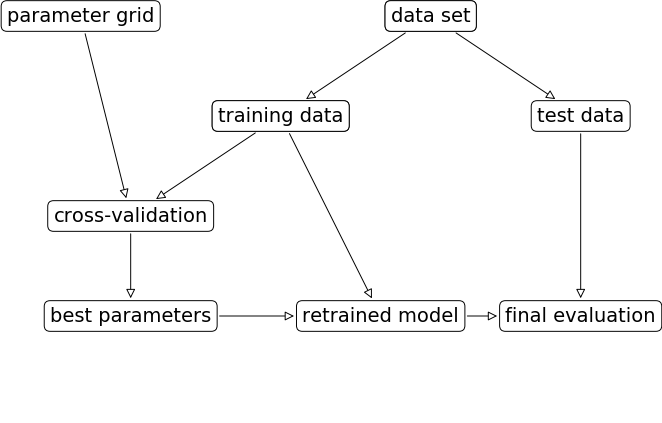

In [10]:
# so let's follow the below method but including RFE and not including RFE
mglearn.plots.plot_grid_search_overview()

In [11]:
#now let's do recursive feature elimnation
#let's set number of features to select
num_features_select=15
print("Number of columns in the encoded data set",df_bd.shape[1])
features_selected=rfe(num_features_select,df_bd,pred_df)
data=df_bd[features_selected]

Number of columns in the encoded data set 42
Fitting estimator with 42 features.
Fitting estimator with 32 features.
Fitting estimator with 22 features.
15 selected features


<a id ='section4'></a>

Size of training set: 5608 size of validation set: 1870 size of test set: 2493



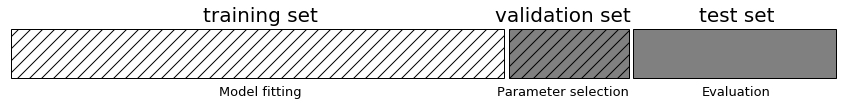

In [12]:
#let's use data to split into train, test and validation
(X_trainval, X_test, y_trainval, y_test),(X_train, X_valid, y_train, y_valid)=splitdata(data,pred_df)
print("Size of training set: {} size of validation set: {} size of test set:"
" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

mglearn.plots.plot_threefold_split()

### steps to follow 
1. choose 1 method of encoding 
2. do Recursive Feature eleimination [select best columns]
3. split the data
4. scale the data  
5. now build the model using GridSearchCV. Do a parameter tuning using Validation data
6. again build the model with best parameter 
7. evaluate the model on the test data
8. evalutaion using Confusion matrix, Accuracy, micro and macro [precision, recall and f1 score.]

In [13]:
best_score=0
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # for each combination of parameters, train an SVC
    model = LogisticRegression(solver="lbfgs",multi_class="multinomial",C=C)
    model.fit(X_train, y_train)
    
    score = accuracy_score(y_valid,model.predict(X_valid))
    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameters = {'C': C}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
print(best_parameters)

model = LogisticRegression(solver="lbfgs",multi_class="multinomial",C=best_parameters['C'],max_iter=4000)
model.fit(X_trainval, y_trainval)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = model.predict(X_test)
print('Target on test data',predict_test) 

# Accuray Score on test dataset
accuracy_test= accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)



{'C': 0.01}
Target on train data [15.  7.  8. ...  8.  7. 14.]
accuracy_score on train dataset :  0.6356990014265336
Target on test data [6. 2. 8. ... 6. 7. 3.]
accuracy_score on test dataset :  0.631768953068592


In [14]:
#since the train, test and validate split the data not so uniformly
#the accuracy is about 63%
y_train['hh_inco'].value_counts()
# as you can see the score
#it's about 63%



15.0    954
6.0     610
7.0     590
14.0    532
8.0     465
9.0     396
4.0     381
5.0     378
3.0     332
10.0    307
2.0     235
12.0    168
1.0     161
13.0     99
Name: hh_inco, dtype: int64

<a id ='section5'></a>

### let's use Grid searchCV with 10 folds
1. calculate the mean accuracy 
2. use it on all three encoding

In [15]:
def train(X_train,y_train):

    grid={"C":np.logspace(-3,3,8)} 
    logreg=LogisticRegression(solver="lbfgs",multi_class="multinomial")
    logreg_cv=GridSearchCV(logreg,grid,cv=2)
    logreg_cv.fit(X_train,y_train)
    return logreg_cv

def predict(X_train,y_train,X_test,y_test,logreg_cv):
    # predict the target on the train dataset
    predict_train = logreg_cv.predict(X_train)
    print('Target on train data',predict_train) 

    # Accuray Score on train dataset
    accuracy_train = accuracy_score(y_train,predict_train)
    print('accuracy_score on train dataset : ', accuracy_train)

    # predict the target on the test dataset
    predict_test = logreg_cv.predict(X_test) 
    print('Target on test data',predict_test) 
    
    # Accuray Score on test dataset
    accuracy_test= accuracy_score(y_test,predict_test)
    print('accuracy_score on test dataset : ', accuracy_test)
    
    
    return logreg_cv,predict_train,predict_test
    
    
def params(result,columns,key):
    for logreg_cv in result.values():
        print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
        print("accuracy :",logreg_cv.best_score_)
        print("Best estimator:\n{}".format(logreg_cv.best_estimator_))
        results = pd.DataFrame(logreg_cv.cv_results_)       
        plt.plot(logreg_cv.best_estimator_.coef_.T,'^', label=logreg_cv.best_params_['C'])
        plt.xticks(range(len(columns)),columns, rotation=90)
        plt.hlines(0, 0, len(columns))
        plt.ylim(-5, 5)
        plt.xlabel("Feature")
        plt.ylabel("Coefficient magnitude")
        plt.title(key)
        plt.show()
        return results

In [16]:
#Grid search CV with 10 folds
# so let's use all the encoders and with 10 to 30 features range

def build(dataframes,num_features):
    for key,values in dataframes.items():
        print("Using the ",key," encoded Data")
        print(num_features," features to be restricted to")
        print("Number of columns in the encoded data set",values.shape[1])
        print("Performing Recursive feature selection")
        features_selected=rfe(num_features,values,pred_df)
        print(features_selected)
        data=values[features_selected]
        X_train, X_test, y_train, y_test = train_test_split(
        data, pred_df, random_state=0,test_size=0.2)

        X_train,X_test=scalingdata(X_train,X_test)
        logreg=train(X_train,y_train)
        results={}
        results['df_bd'],predict_train,predict_test=predict(X_train,y_train,X_test,y_test,logreg)
        final=params(results,features_selected,key)
        print(classification_report(y_test, predict_test))
        return final

<a id ='section6'></a>

Using the  onehot  encoded Data
20  features to be restricted to
Number of columns in the encoded data set 60
Performing Recursive feature selection
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30 features.
20 selected features
['hh_size', 'fm_size', 'f_inc', 'f_pir', 'p_race_nhis_asian', 'p_race_nhis_black', 'p_race_nhis_white', 'p_citz_yes_citz', 'f_ilang_fam_lan_int_eng', 'f_ilang_fam_lan_int_spa', 'f_iprox_ff_prox_no', 'f_intrp_fam_intrp_yes', 'mec_prox_mec_prox_no', 'aca_lang_aca_lan_int_asi', 'aca_lang_aca_lan_int_spa', 'hh_born_hh_born_not_us', 'hh_marl_hh_married', 'hh_marl_hh_never_married', 'hh_marl_hh_separated', 'hh_marl_hh_widowed']
Target on train data [15. 15.  7. ... 15.  7. 15.]
accuracy_score on train dataset :  0.8317452357071213
Target on test data [ 6.  2.  9. ... 15. 15.  4.]
accuracy_score on test dataset :  0.8235588972431078
tuned hpyerparameters :(best parameters)  {'C': 1000

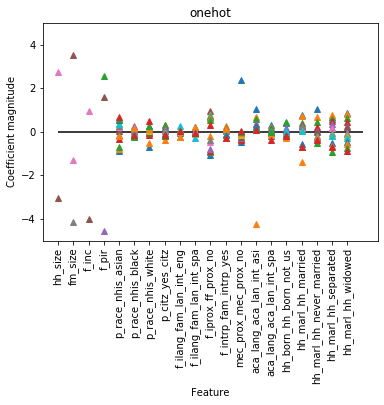

              precision    recall  f1-score   support

         1.0       0.89      1.00      0.94        49
         2.0       0.96      0.93      0.95        88
         3.0       0.95      0.92      0.93       118
         4.0       0.78      0.89      0.83       123
         5.0       0.88      0.65      0.74       130
         6.0       0.81      0.89      0.85       205
         7.0       0.80      0.95      0.87       202
         8.0       0.96      0.86      0.91       182
         9.0       0.78      0.88      0.83       129
        10.0       0.70      0.66      0.68       112
        12.0       0.53      0.13      0.21        63
        13.0       0.52      0.43      0.47        28
        14.0       0.75      0.67      0.71       217
        15.0       0.83      0.93      0.88       349

    accuracy                           0.82      1995
   macro avg       0.80      0.77      0.77      1995
weighted avg       0.82      0.82      0.81      1995



mean_fit_time  std_fit_time  mean_score_time  std_score_time     param_C  \
0       0.114540      0.020775         0.002000        0.002000       0.001   
1       0.103794      0.005578         0.000000        0.000000  0.00719686   
2       0.187475      0.000012         0.007811        0.007811   0.0517947   
3       0.336048      0.007925         0.000000        0.000000    0.372759   
4       0.320289      0.007815         0.000000        0.000000      2.6827   
5       0.328170      0.000041         0.000000        0.000000      19.307   
6       0.320361      0.007716         0.000000        0.000000      138.95   
7       0.351528      0.007823         0.000000        0.000000        1000   

                         params  split0_test_score  split1_test_score  \
0                  {'C': 0.001}           0.295164           0.295107   
1  {'C': 0.0071968567300115215}           0.374593           0.376913   
2     {'C': 0.0517947467923121}           0.480331           0.489837   
3     {'C': 0.3727593720314938}           0.571035           0.610038   
4     {'C': 2.6826957952797246}           0.671260           0.713927   
5     {'C': 19.306977288832496}           0.755951           0.792723   
6      {'C': 138.9495494373136}           0.786770           0.809787   
7                 {'C': 1000.0}           0.792032           0.813802   

   mean_test_score  std_test_score  rank_test_score  
0         0.295135        0.000029                8  
1         0.375752        0.001160                7  
2         0.485080        0.004753                6  
3         0.590522        0.019501                5  
4         0.692578        0.021333                4  
5         0.774323        0.018386                3  
6         0.798270        0.011508                2  
7         0.802909        0.010885                1

In [17]:
dataframes={'onehot':df_onehot}
num_features=20
build(dataframes,num_features)


<a id ='section7'></a>

Using the  hashing  encoded Data
15  features to be restricted to
Number of columns in the encoded data set 19
Performing Recursive feature selection
Fitting estimator with 19 features.
15 selected features
['hh_size', 'fm_size', 'hh_chld5', 'hh_adult', 'hh_edu', 'f_inc', 'f_pir', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7']
Target on train data [15. 15.  7. ... 15.  7. 15.]
accuracy_score on train dataset :  0.8243480441323972
Target on test data [ 6.  2.  9. ... 15. 15.  4.]
accuracy_score on test dataset :  0.8235588972431078
tuned hpyerparameters :(best parameters)  {'C': 1000.0}
accuracy : 0.8139418254764292
Best estimator:
LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


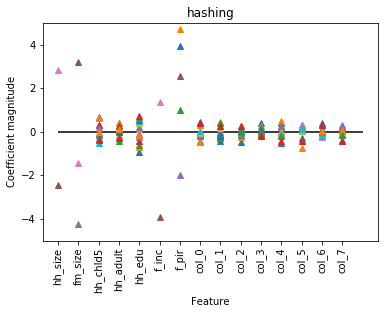

              precision    recall  f1-score   support

         1.0       0.88      1.00      0.93        49
         2.0       0.97      0.94      0.95        88
         3.0       0.93      0.93      0.93       118
         4.0       0.85      0.83      0.84       123
         5.0       0.85      0.74      0.79       130
         6.0       0.84      0.91      0.88       205
         7.0       0.84      0.95      0.89       202
         8.0       0.95      0.86      0.90       182
         9.0       0.71      0.84      0.77       129
        10.0       0.69      0.62      0.65       112
        12.0       0.46      0.17      0.25        63
        13.0       0.45      0.32      0.38        28
        14.0       0.77      0.68      0.72       217
        15.0       0.81      0.93      0.87       349

    accuracy                           0.82      1995
   macro avg       0.78      0.77      0.77      1995
weighted avg       0.82      0.82      0.82      1995



mean_fit_time  std_fit_time  mean_score_time  std_score_time     param_C  \
0       0.099295      0.000698         0.002003        0.002003       0.001   
1       0.123627      0.028333         0.004100        0.004100  0.00719686   
2       0.216757      0.047179         0.002001        0.002001   0.0517947   
3       0.323252      0.004830         0.000000        0.000000    0.372759   
4       0.320289      0.007814         0.000000        0.000000      2.6827   
5       0.312597      0.000140         0.000000        0.000000      19.307   
6       0.515237      0.016653         0.003995        0.000005      138.95   
7       0.522071      0.018212         0.001999        0.001999        1000   

                         params  split0_test_score  split1_test_score  \
0                  {'C': 0.001}           0.288148           0.288080   
1  {'C': 0.0071968567300115215}           0.338261           0.348808   
2     {'C': 0.0517947467923121}           0.468053           0.497616   
3     {'C': 0.3727593720314938}           0.578802           0.618068   
4     {'C': 2.6826957952797246}           0.672513           0.730238   
5     {'C': 19.306977288832496}           0.763718           0.803262   
6      {'C': 138.9495494373136}           0.800551           0.822585   
7                 {'C': 1000.0}           0.801804           0.826098   

   mean_test_score  std_test_score  rank_test_score  
0         0.288114        0.000034                8  
1         0.343531        0.005273                7  
2         0.482823        0.014781                6  
3         0.598420        0.019633                5  
4         0.701354        0.028863                4  
5         0.783475        0.019772                3  
6         0.811560        0.011017                2  
7         0.813942        0.012147                1

In [18]:
dataframes={'hashing':df_hash}
num_features=15
build(dataframes,num_features)


<a id ='section8'></a>

In [19]:
dataframes={'backward_difference':df_bd}
num_features=20
build(dataframes,num_features)


Using the  backward_difference  encoded Data
20  features to be restricted to
Number of columns in the encoded data set 42
Performing Recursive feature selection
Fitting estimator with 42 features.
Fitting estimator with 32 features.
Fitting estimator with 22 features.
20 selected features
['hh_size', 'fm_size', 'hh_adult', 'f_inc', 'f_pir', 'p_race_0', 'p_race_1', 'p_race_3', 'p_citz_0', 'p_ilang_0', 'f_ilang_0', 'f_intrp_0', 'mec_lang_0', 'aca_lang_1', 'hh_born_0', 'hh_marl_0', 'hh_marl_1', 'hh_marl_2', 'hh_marl_3', 'hh_marl_4']
Target on train data [15. 15.  7. ... 15.  7. 15.]
accuracy_score on train dataset :  0.8172016048144434
Target on test data [ 6.  2.  9. ... 15. 15.  4.]
accuracy_score on test dataset :  0.8100250626566416
tuned hpyerparameters :(best parameters)  {'C': 1000.0}
accuracy : 0.7912487462387161
Best estimator:
LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
    

              precision    recall  f1-score   support

         1.0       0.89      1.00      0.94        49
         2.0       0.96      0.92      0.94        88
         3.0       0.91      0.92      0.91       118
         4.0       0.79      0.84      0.81       123
         5.0       0.85      0.61      0.71       130
         6.0       0.77      0.85      0.81       205
         7.0       0.76      0.94      0.84       202
         8.0       0.94      0.82      0.88       182
         9.0       0.74      0.83      0.78       129
        10.0       0.66      0.62      0.64       112
        12.0       0.70      0.25      0.37        63
        13.0       0.52      0.43      0.47        28
        14.0       0.79      0.70      0.74       217
        15.0       0.84      0.94      0.88       349

    accuracy                           0.81      1995
   macro avg       0.79      0.76      0.77      1995
weighted avg       0.81      0.81      0.80      1995



mean_fit_time  std_fit_time  mean_score_time  std_score_time     param_C  \
0       0.116148  6.779552e-03         0.000000        0.000000       0.001   
1       0.105904  1.216066e-02         0.000000        0.000000  0.00719686   
2       0.210912  7.822394e-03         0.007812        0.007812   0.0517947   
3       0.320302  7.823706e-03         0.000000        0.000000    0.372759   
4       0.334828  6.750226e-03         0.001997        0.001997      2.6827   
5       0.326671  1.429319e-03         0.000000        0.000000      19.307   
6       0.328102  4.768372e-07         0.000000        0.000000      138.95   
7       0.328235  1.122952e-04         0.000000        0.000000        1000   

                         params  split0_test_score  split1_test_score  \
0                  {'C': 0.001}           0.297169           0.290841   
1  {'C': 0.0071968567300115215}           0.349536           0.370389   
2     {'C': 0.0517947467923121}           0.472563           0.483312   
3     {'C': 0.3727593720314938}           0.566274           0.608281   
4     {'C': 2.6826957952797246}           0.663994           0.717189   
5     {'C': 19.306977288832496}           0.741168           0.785194   
6      {'C': 138.9495494373136}           0.753696           0.804768   
7                 {'C': 1000.0}           0.773240           0.809285   

   mean_test_score  std_test_score  rank_test_score  
0         0.294007        0.003164                8  
1         0.359955        0.010426                7  
2         0.477934        0.005375                6  
3         0.587262        0.021003                5  
4         0.690572        0.026598                4  
5         0.763164        0.022013                3  
6         0.779213        0.025536                2  
7         0.791249        0.018023                1